In [1]:
import numpy, matplotlib.pyplot as plt
from transformers import AutoTokenizer, GPT2Tokenizer, GPT2LMHeadModel, RobertaForSequenceClassification

from BatchTextGenerationPipeline import BatchTextGenerationPipeline
from IsFakePipeline import IsFakePipeline

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

detector_tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
detector_model = RobertaForSequenceClassification.from_pretrained("roberta-base-openai-detector")

classifier = IsFakePipeline(model=detector_model, tokenizer=detector_tokenizer)
generator = BatchTextGenerationPipeline(model=model, tokenizer=tokenizer)

summarize = lambda classifications: {
    "min": classifications.min(initial=1),
    "mean": classifications.mean(),
    "meanAbsDev": abs(classifications - classifications.mean()).mean(),
    "max": classifications.max(initial=0)
}

describe = lambda texts: summarize(numpy.array(classifier(texts)))

In [2]:
experiments = 100
generate_p = lambda top_p: generator.generate(
    prompt="",
    generate_length=30,
    num_return_sequences=experiments,
    top_p=top_p,
    no_repeat_ngram_size=3,
    do_sample=True
)
generate_k = lambda top_k: generator.generate(
    prompt="",
    generate_length=30,
    num_return_sequences=experiments,
    top_k=top_k,
    no_repeat_ngram_size=3,
    do_sample=True
)

top_p = [0.50, 0.67, 0.78, 0.85, 0.90, 0.93, 0.96, 0.97, 0.98, 0.99]
top_k = [3, 5, 8, 13, 21, 34, 55, 89, 144, 233]

In [3]:
means_p = [describe(generate_p(p))['mean'] for p in top_p]

In [4]:
means_k = [describe(generate_k(k))['mean'] for k in top_k]

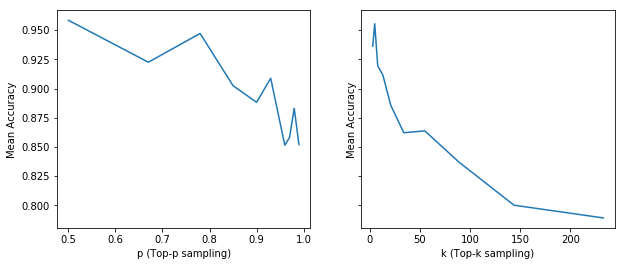

In [24]:
_, axes = plt.subplots(1, 2, figsize=[10, 4], sharey=True)

fig = axes[0]
fig.plot(top_p, means_p)
fig.set_ylabel("Mean Accuracy")
fig.set_xlabel("p (Top-p sampling)")
fig = axes[1]
fig.plot(top_k, means_k)
fig.set_ylabel("Mean Accuracy")
fig.set_xlabel("k (Top-k sampling)")
plt.savefig('./gpt2-vs-acc.png')
plt.show()

In [6]:
generate_p_l = lambda length: generator.generate(
    prompt="",
    generate_length=length,
    num_return_sequences=experiments,
    top_p=0.99,
    no_repeat_ngram_size=3,
    do_sample=True
)
generate_k_l = lambda length: generator.generate(
    prompt="",
    generate_length=length,
    num_return_sequences=experiments,
    top_k=150,
    no_repeat_ngram_size=3,
    do_sample=True
)

lengths = [3, 5, 7, 11, 20, 30, 50, 100]

In [7]:
means_p_l = [describe(generate_p_l(l))['mean'] for l in lengths]

In [8]:
means_k_l = [describe(generate_k_l(l))['mean'] for l in lengths]

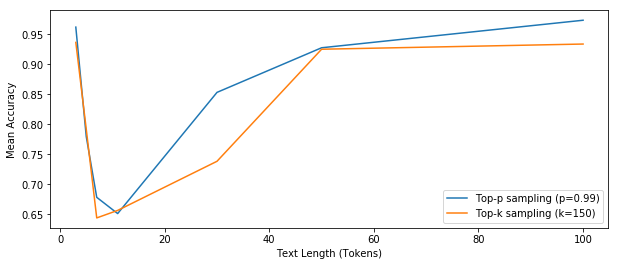

In [22]:
plt.figure(figsize=[10, 4])
fig = plt.gca()
fig.plot(lengths, means_p_l, label="Top-p sampling (p=0.99)")
fig.plot(lengths, means_k_l, label="Top-k sampling (k=150)")
fig.set_ylabel("Mean Accuracy")
fig.set_xlabel("Text Length (Tokens)")
fig.legend()
plt.savefig('./gpt2-length-vs-acc.png')
plt.show()

In [ ]:
def advDecode(prompt):
    for i in range(5):
        texts = generator.generate(prompt=prompt, generate_length=10, num_return_sequences=5, do_sample=True, top_p=0.99, no_repeat_ngram_size=3)
        prompt, classification = classifier.getLeastFake(texts)
        print("\n\n", classification, prompt)